# CAB420 - Dealing with Multi-Dimensional Arrays
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

When we train and evaluate machine learning models, we will typically pass multiple samples to a model at once. For example, we may pass the entire dataset in a single variable (or two variables, one for the input and one for the expected output) to a model training function. This means that we'll typically be dealing with multi-dimensional arrays, and at times we'll need to manipulate these to either look at individual samples, or rearange the data so that it fits into the shape expected by whatever model (or display function) we are using. This example will look at how we can manipulate these arrays.

There are four main operations that we'll focus on:
* Indexing into arrays: We can pull out single elements or chunks (slices), and use negative indicies to index starting at the back of an array.
* Reshaping an array: This involves changing the shape of an array, but not changing the total number of elements in an array. A good example of this (that we'll use a lot) is vectorising an image.
* Transposing an array: This involves changing the order of the dimensions. We'll often use this when we need to ensure that the dimension that corresponds to the index of a sample is a particular location.
* Adding and removing dimensions: Perhaps unsurpisingly, this involves adding and removing dimensions. We won't use this much, but will sometimes need to add a dimension to get the data into an expected shape for some other operation. We'll have fewer cases where we need to remove one.

One thing we're not covering here is resizing. There are a couple of reasons for this:
* Resizing methods are specific to individual data types. For images we have image resize methods that use interpolation, for audio samples we have resampling function. For tabular data I'd argue the idea of 'resizing' makes a bit less sense, but there are interpolation or aggregration methods that we can use. This guide is focussing on more generic data manipulation, resizing simply isn't generic.
* We're not going to use resizing much in CAB420, and where we do we will give you the code to do it (mostly - the exception would be Assignment 2, but you can ask for help).

## Why do we need to manipulate arrays?

As a bit of context up top, let's look at why this is important. All of our machine learning methods are going to take data as input, and produce some output (which is more data). And then we'll want to compare what the model produces with the ground truth. All of this will be stored as arrays, and it will often be arrays with 2 or more dimensions. Furthermore, our models will want the input data, and generate output data, in a certain way - so we may need to manipulate arrays to get them into or out of these formats.

Considering our individual models, they'll want data in the following form:
* Regression: Our inputs (the X data, also known as the predictors) will be a 2D array. The rows will be the individual samples (or observations), the columns will be the individual variables. Our output will be a column vector.
* Classification (SVM/RF/CKNN): The same format as regression, 2D inputs (samples, variables), 1D output.
* Clustering (GMM/K-Means): The input will again be 2D, (samples, variables). There is no ground truth with clustering.
* Deep Nets: The input will be n-dimensional, where N is two or more. This will typically be (samples, other dimensions, ...). How many dimensions depends on the data you are using, but for images we'd have a 4D input, (samples, image width, image height, number of channels). The output is also very flexible and depends on what the network is doing.

The key message here is not so much the exact form of the data (though that's obviously important), but that there is an exact form of the data that we have to match. As such, being able to manipulate data into the form that we need is critical. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from scipy.datasets import face
import numpy
import keras
import matplotlib.pyplot as plt

## Some Data and what it looks like

We need some data to start with. We'll use three things, with increasing numbers of dimensions:
* A $4\times 4$ matrix, containing the numbers [1..16]
* A colour image which has three dimensions: a width, height and number of channels (3: red, green and blue).
* An array of images, which has four dimensions: the samples, the image width, height and number of channels.

For each lump of data, we'll also display it in some way and check it's shape. Numpy array's have a `shape` attribute that tell us the number of dimensions, and the number of indexes in each dimension. This is helpful for checking what the data actually is. You can use this to check firstly that the data has loaded properly and is the size (or roughly the size) that you expect, and also to work out what you need to do next. 

How we display data depends on the data itself. For small arrays we can just print them, for images we use matplotlib and show them. For huge image datasets with thousands of images, we can show a few sample images. For tabular data (which we're not using here) we could plot things. Alongside checking the shape of arrays that you load, having a quick visualisation of the data is great as a sanity check to make sure that it's actually loaded properly.

In [2]:
# 2D array
an_array = numpy.arange(0, 16, 1).reshape((4,4))
print(an_array.shape)
print(an_array)

(4, 4)
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


(768, 1024, 3)


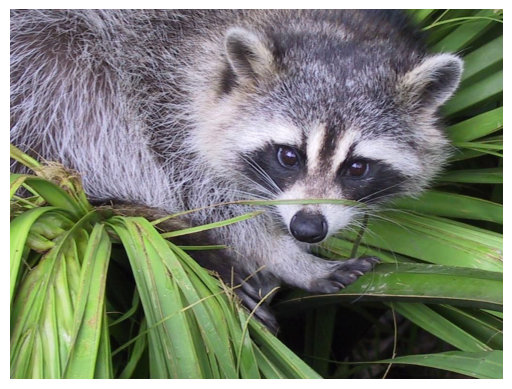

In [3]:
# sample image
trash_panda = face()
# just print the shape rather than the whole thing - it's quite large
print(trash_panda.shape)

# the image itself
plt.imshow(trash_panda)
plt.axis('off')
plt.show()

(50000, 32, 32, 3)


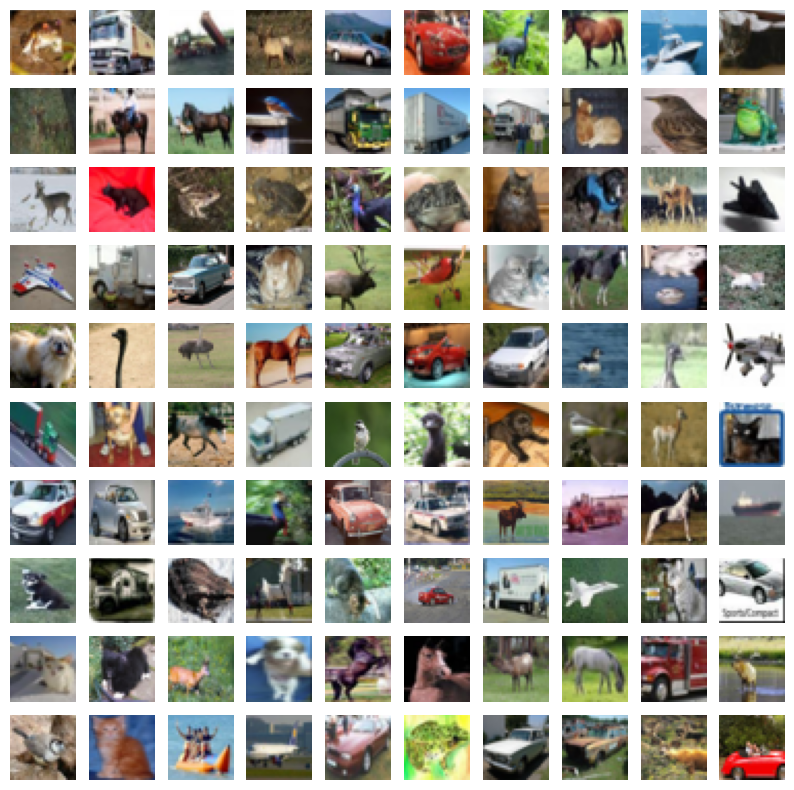

In [4]:
# load cifar10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# again just print the shape rather than the whole thing - this is huge
print(x_train.shape)

# some images
fig = plt.figure(figsize=[10,10])
for i in range(10):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10 + j + 1)
        ax.imshow(x_train[i*10 + j, :])
        ax.axis('off')

## Indexing

Before we get into manipulating these, let's quickly run through indexing into these. We can pull out individual elements, individual rows or columns, or sub arrays as we see fit. 

In [5]:
print(an_array)

# one element, top-left corner
print(an_array[0,0])

# one row, top row in this case
print(an_array[0,:])

# one column, first column in this case
print(an_array[:,0])

# sub-array
print(an_array[1:3,1:3])

# pulling out a single element of a 4D array
print(x_train[0,0,0,0])

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
0
[0 1 2 3]
[ 0  4  8 12]
[[ 5  6]
 [ 9 10]]
59


The one key piece of syntax in the above is the use of `:`.

The `:` operator effectivley means all, so we can use this to select all indexes in a given dimension. We will use this most often for pulling out individual samples from a dataset. In practice one of our dimensions will typically be the sample dimension, so we can do something like the below to pull out one (or more samples from the data).

(Note in the below I'm just printing the shape rather than the actual data, as the actual data is a lot of values)

In [6]:
# first sample from mnist training set
print(numpy.shape(x_train[0,:,:,:]))

# first 10 samples from mnist training set
print(numpy.shape(x_train[0:10,:,:,:]))

(32, 32, 3)
(10, 32, 32, 3)


We don't actually need to specify all dimensions when we index into an array either. If we have a 4D array and only specify the first dimension, numpy and python will treat the others as `:`

In [7]:
# pull out the first sample, but only use one index 
print(numpy.shape(x_train[0]))
# confirm that this is the same as using : for all other dimensions
print(numpy.array_equal(x_train[0], x_train[0,:,:,:]))

(32, 32, 3)
True


Finally, we'll briefly look at using negative indexes. This is a really handy way to pull out the last (or last N) elements of something.

This can be particularly useful if we have a dataset where the last column of some array is the response (i.e. model output), so we can easily grab everything but the last column as the input, and then the last column as the output, without needing to actually know how many columns are actually in the data.

In [8]:
pretend_X = an_array[:,:-1]
pretend_Y = an_array[:,-1]
print(pretend_X)
print(pretend_Y)

[[ 0  1  2]
 [ 4  5  6]
 [ 8  9 10]
 [12 13 14]]
[ 3  7 11 15]


### A brief note about how arrays are stored

In python, essentially everything is a pointer. If you don't know what this means, observe:

In [9]:
# copy an_array
an_array_2 = an_array
# change a value in an_array_2 to a really awesome number
an_array_2[0,0] = 42
# print out an_array_2
print(an_array_2)
# print out the OG an_array
print(an_array)

[[42  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[42  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


When we copied `an_array`, i.e. `an_array_2 = an_array`, we didn't actually duplicate it - we just created another variable pointing to the same bit of memory. This means that when we change something in `an_array_2`, we also change than thing in `an_array`. This behaviour holds even if we take a slice of an array:

In [10]:
# grab a part of an array
slice_of_an_array = an_array[0:2,:]
# commit some evil deed to that portion of the array
slice_of_an_array[-1,-1] = 666
# now print stuff
print(slice_of_an_array)
print(an_array)

[[ 42   1   2   3]
 [  4   5   6 666]]
[[ 42   1   2   3]
 [  4   5   6 666]
 [  8   9  10  11]
 [ 12  13  14  15]]


If we actually want a copy of something, we need to explicitly ask for it.

In [11]:
# make an actual copy
a_copy_of_an_array = an_array.copy()
# is there any deep meaning to the unit code for this unit being CAB420, and 420 = 42 x 10?
a_copy_of_an_array[-1,0] = 420
# print more stuff
print(a_copy_of_an_array)
print(an_array)

[[ 42   1   2   3]
 [  4   5   6 666]
 [  8   9  10  11]
 [420  13  14  15]]
[[ 42   1   2   3]
 [  4   5   6 666]
 [  8   9  10  11]
 [ 12  13  14  15]]


So, should you just use `.copy() ` everywhere? No. That would probably be bad for your memory use. We'll spend a lot of CAB420 playing with big arrays. Consider the cifar10 dataset we loaded above, the training set for that is about 150 MB

In [12]:
x_train.size / (1024*1024)

146.484375

While this isn't huge, it's not tiny either, and it's not the sort of thing you want to make lots of copies of unless you need to. For the most part with arrays, what we'll be doing is non-destructive (i.e. we can reverse it). Any operation that actually changes the underlying data, like a resize, will create a copy of the data anyway. If you start doing destructive operations to the data and want to maintain a copy of the original, then use `.copy()`, but for the most part this is not something you'll need to worry about. Nonetheless, being aware of how this stuff is stored in memory is worthwhile.

## Reshaping

Reshaping will change the shape of an array - but critically the number of elements in the array remains the same. Generally we will use reshape remove/combine dimensions, such as when we flatten an image to vector. This is a common operation we will use when preparing data to go into our various ML models. Within CAB420 it will be a bit less common for us to add dimensions via a reshape unless we're simply trying to undo the earlier flatten.

In [13]:
# flatten the 4x4 array into a 1D array
an_array_as_a_vector = an_array.reshape(16)
print(an_array_as_a_vector)

# can't be bothered doing 4x4? Just put -1 and let python work it out
an_array_as_a_vector = an_array.reshape(-1)
print(an_array_as_a_vector)

# and reshape back the other way
print(an_array_as_a_vector.reshape(4,4))

[ 42   1   2   3   4   5   6 666   8   9  10  11  12  13  14  15]
[ 42   1   2   3   4   5   6 666   8   9  10  11  12  13  14  15]
[[ 42   1   2   3]
 [  4   5   6 666]
 [  8   9  10  11]
 [ 12  13  14  15]]


Looking explicitly at the practical uses of reshape in CAB420, we've got three main things that we're going to use it for. The first of these is vectorising data. A number of our models (anything not a deep net) will want data in a 2D array, where each row is a sample. When each sample is not actually a vector, that means we need to do some reshaping. Here's how we would vectorise the CIFAR10 training set:

In [14]:
# reshape into 2 dimensions, we only need to specify the size of one of these and numpy can then work out the other automatically. We know that each
# image is 32x32x3, so we can use that to spec the number of columns (essentially the number of variables in each sample), and then let python check how many 
# samples (rows) we need
vectorised_xtrain = x_train.reshape(-1, 32*32*3)
# print the shape to confirm
print(vectorised_xtrain.shape)

(50000, 3072)


Often times, we'll also want to go the other way. We'll not normally want to reshape the whole dataset, but perhaps a few samples. Maybe we tried training a model and found a few samples on which the model did rather poorly, so we'd like to inspect those samples. Here, we can simply select the sample we're interested in, and then reshape that back into our original image.

(32, 32, 3)


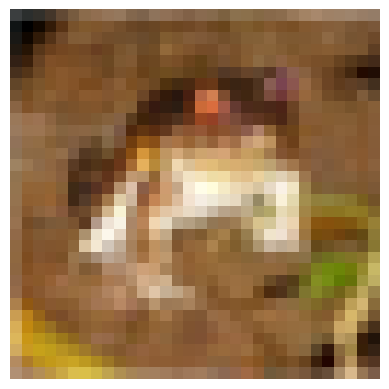

In [15]:
a_reshaped_image = vectorised_xtrain[0].reshape(32, 32, 3)
print(a_reshaped_image.shape)
plt.imshow(a_reshaped_image)
plt.axis('off')
plt.show()

and we get a very small image of (what I think is) a frog.

The third use is a bit weirder. Let's pretend we're regression model. We've got some ground truth, and we've got some predictions. We'd like to compare them and compute an RMSE. These arrays are going to be the same length, so really we'd just like to get some error between corresponding values. Let's pretend our data looks like this:

In [16]:
pretend_model_output = numpy.arange(0, 16).reshape((-1))
pretend_ground_truth = numpy.arange(0, 16).reshape((-1, 1))
print(pretend_model_output.shape)
print(pretend_ground_truth.shape)

(16,)
(16, 1)


This seems fine. We have two vectors, they're the same length. Surely python will just subtract that values and all will be well. If we look at the actual vectors, you might be able to see where this is about to go wrong. 

In [17]:
print(pretend_model_output)
print(pretend_ground_truth)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]]


They are in different orientations. And when we subtract one from the other python decides to subtract each row `pretend_ground_truth` from the only row in `pretend_model_output` to create some nice big square output matrix.

In [18]:
print(pretend_model_output - pretend_ground_truth)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15]
 [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14]
 [ -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13]
 [ -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12]
 [ -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11]
 [ -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10]
 [ -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9]
 [ -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8]
 [ -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7]
 [ -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6]
 [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5]
 [-11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4]
 [-12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3]
 [-13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2]
 [-14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0 

The solution here is to explicitly flatten each of these down to one dimension, so we can do something like this:

In [19]:
print(pretend_model_output.reshape(-1) - pretend_ground_truth.reshape(-1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Here I've thrown the `.reshape(-1)` on both arrays. I don't actaully need it on `pretend_model_output` as it's already in that shape, but putting it there won't cause any issues either.

This problem here is something that you may actually run into when evaluating regression models depending on the way that you're feeding data to them. If you get strange evaluation results, this might actually be the cause.

## Transposing

Transposing invovles swapping the order of the dimensions around. Typically when we call transpose, we'll give the function the new order of the dimensions that we want, so if we have three dimensions, (0, 1, 2), and we want to swap the first two, we can transpose the dimensions into the order (1, 0, 2). Doing this with the trash panda gives the following:

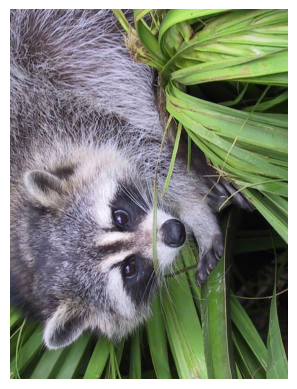

In [20]:
# transpose a picture. Swap the width and height dimensions, leave the channels where they are. This means we'll still have an RGB image, but with 
# rows and columns swapped
sideways_trash_panda = trash_panda.transpose((1,0,2))
# and show it
plt.imshow(sideways_trash_panda)
plt.axis('off')
plt.show()

At this point you might think, "yeah, that's just rotated it", which is not quite right. To perhaps visualise this a bit better, we will transpose our 2D array and print the before and after.

In [21]:
# transpose our array
thing = an_array.transpose((1,0))
print(an_array)
print(thing)

[[ 42   1   2   3]
 [  4   5   6 666]
 [  8   9  10  11]
 [ 12  13  14  15]]
[[ 42   4   8  12]
 [  1   5   9  13]
 [  2   6  10  14]
 [  3 666  11  15]]


From the above, we can see that what's happened is we've swapped the rows and the columns - but the diagonal running from top-left to bottom-right hasn't actually changed.

In terms of practical uses in CAB420, we've really got one main use and that's going to be getting data into the expected shape for our ML models. As best I can remember, within CAB420 all of our models are going to want the sample index as the first dimension. Mostly our data will be in this format, but sometimes we'll instead get something like this.

In [22]:
# break some data, here we'll make the first dimensions the new last dimension
data_in_the_wrong_order = x_train.transpose((1,2,3,0))
print(data_in_the_wrong_order.shape)

(32, 32, 3, 50000)


Here, `data_in_the_wrong_order` has the dimensions as (width, height, channels, samples). We want (samples, width, height, channels). (some of you may have noticed that I had to run a transpose to get this broken order, as it was correct out of the box).

Transpose is how we would correct such as an issue:

In [23]:
# fix the broken data. Our last dimension, which denotes the sample, now becomes the first. This is probably the most common use transpose in CAB420
fixed_data = data_in_the_wrong_order.transpose((3,0,1,2))
print(fixed_data.shape)

(50000, 32, 32, 3)


The end result is our data is (back) in the order we need it to process. When using transpose, I highly recommend printing the shape of the array before and after, at least when you start out, to make sure you've got the transform you want/expect.

## Adding and Removing Dimensions

A related operation is that of adding or removing dimensions. We're probably not going to need to do this very often, but you may find a situations with deep nets where your data is in the shape (samples, width, height) with no explicit channels dimension. In such a case you'll probably find you need to add a fourth dimensions, even though that dimension will just be set to 1. A good example of this is the original MNIST dataset when we load that from keras.

In [24]:
# load mnist, just grab x_train and ignore the rest
(mnist_x_train, _), (_, _) = keras.datasets.mnist.load_data()
# and print the shape
print(mnist_x_train.shape)

(60000, 28, 28)


These are all gray scale images, so each image is just a $28 \times 28$ array. The one channel is implicit, but often we'll actually need to add this in. We can do this using `expand_dims`.

In [25]:
# add an extra dimension, -1 means add it as the last dimension
expanded = numpy.expand_dims(mnist_x_train, -1)
# and now there's a 1 at the back of this
print(expanded.shape)

(60000, 28, 28, 1)


This gets the data into the shape we need, or usually this is as far as you'd need to go with expand_dims. If we need the new dimension somewhere in the middle, we can add it directly into that spot, or add at the back and then transpose it. We can also add multiple new dimensions at once, and use `squeeze` to get rid of all those dimensions of size 1.

In [26]:
# add lots of dimensions
expanded = numpy.expand_dims(mnist_x_train, (0, 2, 4))
print(expanded.shape)

# remove all those extra dimensions we added
shrunk = numpy.squeeze(expanded)
print(shrunk.shape)

(1, 60000, 1, 28, 1, 28)
(60000, 28, 28)


You can also use reshape to do a lot of what we're showing with `expand_dims` and `squeeze`, though I'd suggest that the operations and intent is more obvious with `expand_dims` in particular - so for clarity when you explicitly need to add new dimensions I'd suggest using `expand_dims`.